In [ ]:
!pip3 install google-cloud-aiplatform --user
!pip3 install pyarrow==11.0.0 --user
!pip3 install --upgrade google-cloud-bigquery --user
!pip3 install --upgrade google-cloud-bigquery-storage --user
!pip3 install --upgrade google-cloud-storage --user
!pip install db-dtypes

In [1]:
# Retrieve and set PROJECT_ID and REGION environment variables.
PROJECT_ID = !(gcloud config get-value core/project)
PROJECT_ID = PROJECT_ID[0]

In [2]:
BQ_LOCATION = 'US'
REGION = 'us-west2'

In [3]:
GCS_BUCKET = f"{PROJECT_ID}-asmi"

In [4]:
!gsutil mb -l $REGION gs://$GCS_BUCKET

Creating gs://york-bb-cohort-asmi/...
ServiceException: 409 A Cloud Storage bucket named 'york-bb-cohort-asmi' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


In [5]:
BQ_DATASET = f"{PROJECT_ID}:asmi_bq"

In [6]:
!bq mk --location={BQ_LOCATION} --dataset {BQ_DATASET}

BigQuery error in mk operation: Dataset 'york-bb-cohort:asmi_bq' already exists.


In [8]:
from google.cloud import bigquery
from google.cloud import aiplatform as vertexai
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
vertexai.init(project=PROJECT_ID, location=REGION, staging_bucket=f"gs://{GCS_BUCKET}")

In [29]:
%%bigquery df --project $PROJECT_ID

SELECT 
    *
FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_201701*`



Query is running:   0%|          |

Downloading:   0%|          |

In [30]:
list(df.columns.values)

['visitorId',
 'visitNumber',
 'visitId',
 'visitStartTime',
 'date',
 'totals',
 'trafficSource',
 'device',
 'geoNetwork',
 'customDimensions',
 'hits',
 'fullVisitorId',
 'userId',
 'channelGrouping',
 'socialEngagementType']

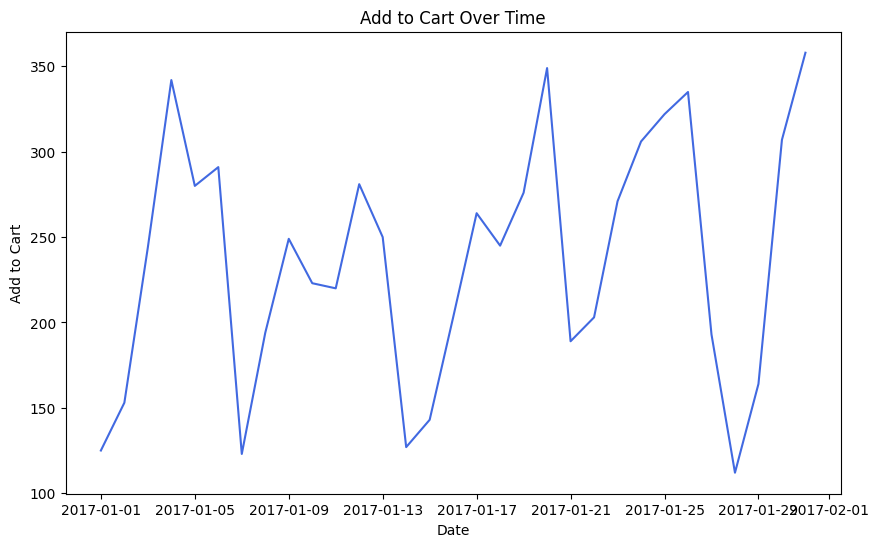

In [14]:
import pandas as pd
import matplotlib.pyplot as plt



query1 = """
SELECT
    date,
    COUNT(*) AS total_count,
    hits.eCommerceAction.action_type AS action_type
FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits
WHERE
    _TABLE_SUFFIX BETWEEN '20170101' AND '20170131' 
    AND hits.eCommerceAction.action_type='3'
GROUP BY
    date,
    action_type
ORDER BY 
    date
"""


result1 = client.query(query1).result().to_dataframe()
result1['date'] = pd.to_datetime(result1['date'])

# Create a figure and axes
fig, ax = plt.subplots(figsize=(16, 6))

# Plot the data
ax.plot(result1['date'], result1['total_count'], color='royalblue')

# Set the title and labels
ax.set_title('Add to Cart Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Add to Cart')

# Show the plot
plt.show()


In [18]:
%%bigquery channel_df --project $PROJECT_ID
SELECT channelGrouping, COUNT(*) as visitor_count
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
    _TABLE_SUFFIX BETWEEN '20170101' AND '20170131' 
GROUP BY channelGrouping
ORDER BY visitor_count DESC


Query is running:   0%|          |

Downloading:   0%|          |

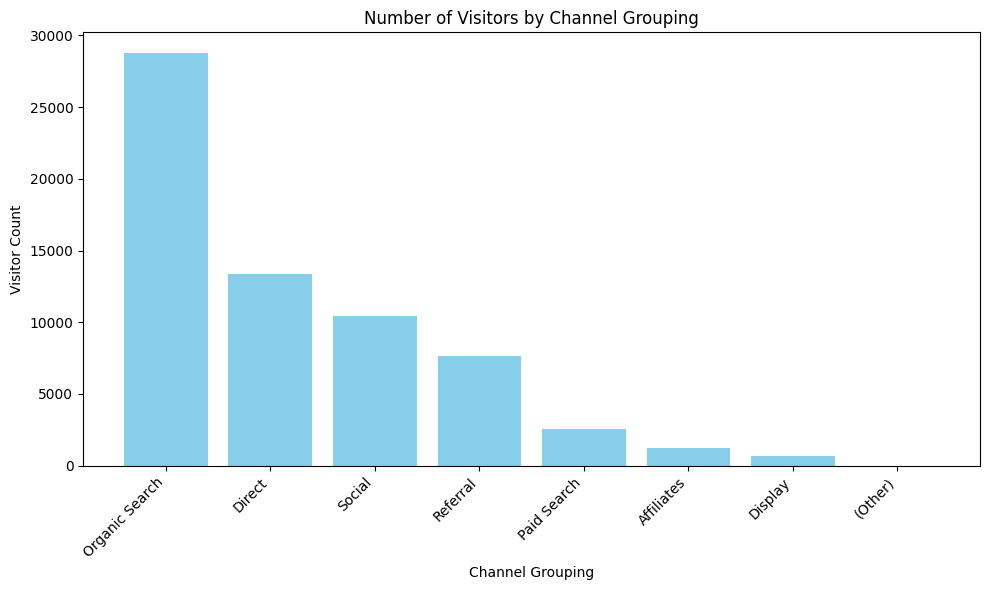

In [19]:
channels = channel_df['channelGrouping']
visitor_counts = channel_df['visitor_count']

# Creating a bar plot
plt.figure(figsize=(10, 6))
plt.bar(channels, visitor_counts, color='skyblue')
plt.xlabel('Channel Grouping')
plt.ylabel('Visitor Count')
plt.title('Number of Visitors by Channel Grouping')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [26]:
%%bigquery country_df --project $PROJECT_ID
SELECT 
    geoNetwork.country AS country,
    COUNT(CASE WHEN hits.eCommerceAction.action_type = '3' THEN fullvisitorId ELSE NULL END ) AS customers
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST (hits) AS hits
GROUP BY 
    country 
ORDER BY 
    customers DESC 

Query is running:   0%|          |

Downloading:   0%|          |

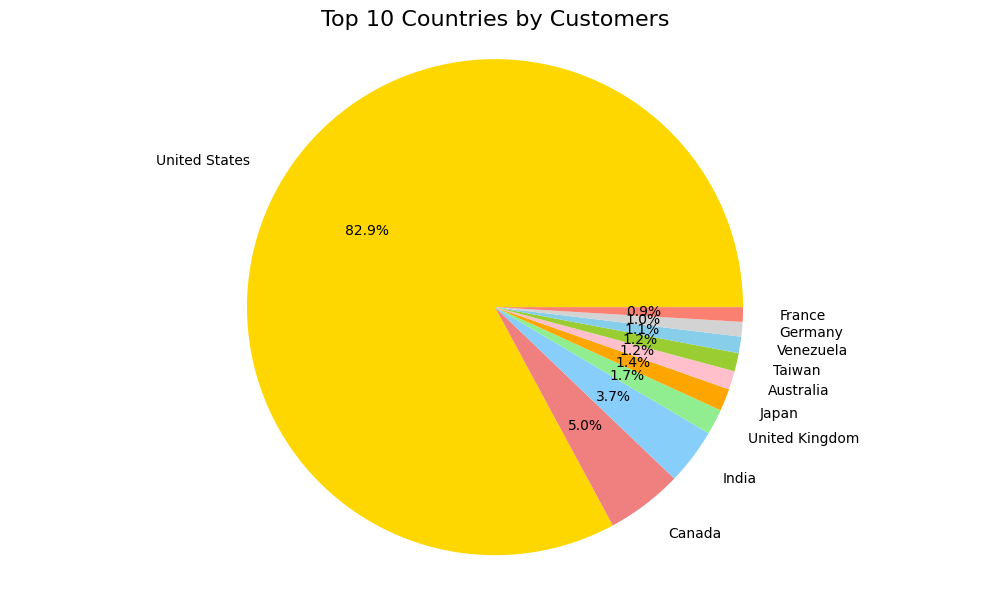

In [27]:


# Extracting data for plotting
countrys = country_df['country'].head(10)
customers =country_df['customers'].head(10)


colors = ['gold', 'lightcoral', 'lightskyblue', 'lightgreen', 'orange', 'pink', 'yellowgreen', 'skyblue', 'lightgrey', 'salmon']

# Plotting
plt.figure(figsize=(10, 6))
plt.pie(customers, labels=countrys, autopct='%1.1f%%', labeldistance=1.15, colors=colors)
plt.title('Top 10 Countries by Customers', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Adjust the layout to prevent overlapping labels
plt.tight_layout()

plt.show()


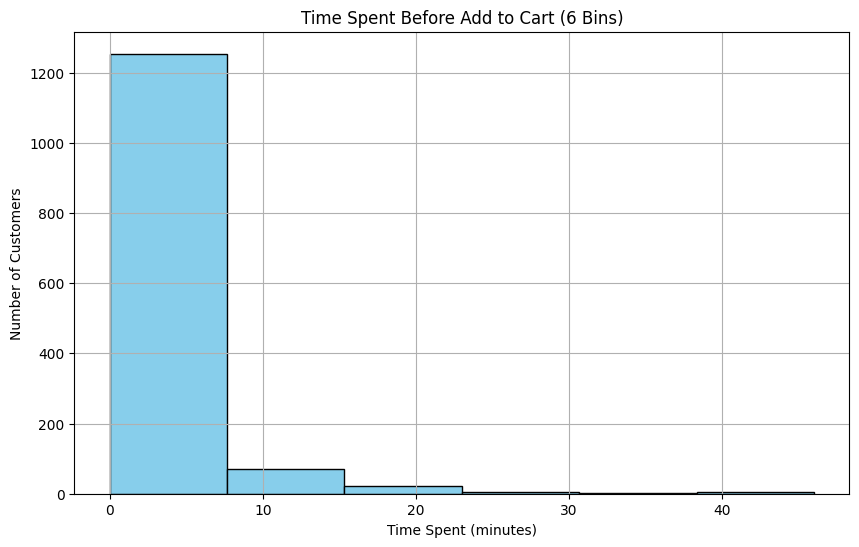

In [21]:
# Execute the SQL query
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()
# Execute the SQL query
query = """
WITH sessions_data AS (
  SELECT
    fullVisitorId,
    hits.time AS hitTime,
    LAG(hits.time) OVER(PARTITION BY fullVisitorId ORDER BY hits.time) AS previousHitTime
  FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits
  WHERE 
    _TABLE_SUFFIX BETWEEN '20170101' AND '20170131' -- Adjust date range as needed
    AND hits.eCommerceAction.action_type = '3' -- Only consider hits with add to cart action
)

SELECT 
  fullVisitorId,
  AVG(CAST((hitTime - previousHitTime) / (1000 * 60) AS INT64)) AS time_spent_before_add_to_cart_minutes
FROM 
  sessions_data
WHERE 
  previousHitTime IS NOT NULL
  GROUP BY 
  fullVisitorId
"""

df = client.query(query).to_dataframe()

# Plot the histogram
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df['time_spent_before_add_to_cart_minutes'], bins=6, color='skyblue', edgecolor='black')
plt.title('Time Spent Before Add to Cart (6 Bins)')
plt.xlabel('Time Spent (minutes)')
plt.ylabel('Number of Customers')
plt.grid(True)
plt.show()


In [ ]:
%%bigquery datadf --project $PROJECT_ID
CREATE OR REPLACE VIEW asmi_bq.mlpredict AS (
WITH first_values AS (
    SELECT
      visitNumber,
      channelGrouping,
      device.deviceCategory AS device_category,
      device.operatingSystem AS operating_system,
      trafficSource.source AS traffic_source,
      trafficSource.medium AS traffic_medium,
      trafficSource.campaign AS traffic_campaign,
      geoNetwork.country AS country,
      geoNetwork.city AS city,
      totals.hits,
      totals.newVisits,
      hits.page.pagePath,
      totals.screenviews,
      totals.timeOnSite AS time_on_site,
      totals.timeOnScreen,
      totals.visits,
      totals.pageviews AS pageviews_per_session,
      hits.hitNumber As number,
      hits.time AS hitTime,
      hits.hour,
      hits.minute, 
      product.v2ProductName,
      product.v2ProductCategory,
     EXTRACT(DAYOFWEEK FROM PARSE_DATE('%Y%m%d', date)) AS day_of_week,
      EXTRACT(HOUR FROM TIMESTAMP_SECONDS(visitStartTime)) AS hourOfVisit,
      IF(hits.eCommerceAction.action_type = '3', 1, 0) AS addToCart
    FROM
      `bigquery-public-data.google_analytics_sample.ga_sessions`,
      UNNEST(hits) AS hits,
     UNNEST(hits.product) AS product
    WHERE
      _TABLE_SUFFIX BETWEEN '20170301' AND '20170331'
  )

  SELECT *
  FROM first_values
    );
    SELECT
  *
FROM
  asmi_bq.mlpredict

In [19]:
%%bigquery data1 --project $PROJECT_ID
CREATE OR REPLACE VIEW asmi_bq.autofeatures2 AS (
WITH first_values AS (
    SELECT
     DISTINCT CONCAT(fullVisitorId, visitId, hits.hitNumber) AS unique_id,
      visitNumber,
      channelGrouping,
      device.deviceCategory AS device_category,
      device.operatingSystem AS operating_system,
      geoNetwork.country AS country,
      geoNetwork.city AS city,
      totals.hits,
      totals.newVisits,
      hits.page.pagePath,
      totals.screenviews,
      totals.timeOnSite AS time_on_site,
      totals.timeOnScreen,
      totals.visits,
      totals.pageviews AS pageviews_per_session,
      hits.hitNumber As number,
      hits.time AS hitTime,
      hits.hour,
      hits.minute, 
      product.v2ProductName,
      product.v2ProductCategory,
     EXTRACT(DAYOFWEEK FROM PARSE_DATE('%Y%m%d', date)) AS day_of_week,
      EXTRACT(HOUR FROM TIMESTAMP_SECONDS(visitStartTime)) AS hourOfVisit,
      IF(hits.eCommerceAction.action_type = '3', 1, 0) AS addToCart
    FROM
      `bigquery-public-data.google_analytics_sample.ga_sessions*`,
      UNNEST(hits) AS hits,
     UNNEST(hits.product) AS product
    WHERE
      _TABLE_SUFFIX BETWEEN '20170101' AND '20170131'
  )

  SELECT *
  FROM first_values
    );
    SELECT
  *
FROM
  asmi_bq.autofeatures

Query is running:   0%|          |

Downloading:   0%|          |

In [20]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1163110 entries, 0 to 1163109
Data columns (total 26 columns):
 #   Column                 Non-Null Count    Dtype 
---  ------                 --------------    ----- 
 0   visitNumber            1163110 non-null  Int64 
 1   channelGrouping        1163110 non-null  object
 2   device_category        1163110 non-null  object
 3   operating_system       1163110 non-null  object
 4   traffic_source         1163110 non-null  object
 5   traffic_medium         1163110 non-null  object
 6   traffic_campaign       1163110 non-null  object
 7   country                1163110 non-null  object
 8   city                   1163110 non-null  object
 9   hits                   1163110 non-null  Int64 
 10  newVisits              838992 non-null   Int64 
 11  pagePath               1163110 non-null  object
 12  screenviews            0 non-null        Int64 
 13  time_on_site           1064132 non-null  Int64 
 14  timeOnScreen           0 non-null 

In [25]:
%%bigquery  --project $PROJECT_ID
CREATE OR REPLACE VIEW asmi_bq.data1 AS (
  WITH first_values AS (
    SELECT
      DISTINCT CONCAT(fullVisitorId, visitId, hits.hitNumber) AS unique_id,
      fullVisitorId,
      visitNumber,
      channelGrouping,
      device.deviceCategory AS device_category,
      device.operatingSystem AS operating_system,
      trafficSource.source AS traffic_source,
      trafficSource.medium AS traffic_medium,
      trafficSource.campaign AS traffic_campaign,
      geoNetwork.country AS country,
      geoNetwork.city AS city,
      totals.bounces,
      totals.hits,
      totals.newVisits,
      totals.timeOnSite AS time_on_site,
      totals.visits,
      totals.pageviews AS pageviews_per_session,
      hits.hitNumber AS number,
      hits.time AS hitTime,
      hits.hour,
      hits.minute, 
      IF(hits.eCommerceAction.action_type = '3', 1, 0) AS addToCart
    FROM
      `bigquery-public-data.google_analytics_sample.ga_sessions_201701*`,
      UNNEST(hits) AS hits
     
  )
  
  SELECT * 
  FROM first_values
);

SELECT
  *
FROM
  asmi_bq.data1;


Query is running:   0%|          |

Downloading:   0%|          |

,unique_id,fullVisitorId,visitId,date,visitNumber,channelGrouping,month,day_of_week,hourOfVisit,device_category,...,hour,minute,pagePath,hostname,pageTitle,pagePathLevel1,pagePathLevel2,pagePathLevel3,pagePathLevel4,addToCart
0,575123099234795270114855006712,5751230992347952701,1485500671,20170126,1,Paid Search,1,5,7,desktop,...,23,4,/home,shop.googlemerchandisestore.com,Home,/home,,,,0
1,575123099234795270114855006713,5751230992347952701,1485500671,20170126,1,Paid Search,1,5,7,desktop,...,23,4,/google+redesign/apparel/men++s/men++s+outerwear,shop.googlemerchandisestore.com,Men's Outerwear | Apparel | Google Merchandise...,/google+redesign/,/apparel/,/men++s/,/men++s+outerwear,0
2,575123099234795270114855006714,5751230992347952701,1485500671,20170126,1,Paid Search,1,5,7,desktop,...,23,5,/google+redesign/apparel/men++s/men++s+outerwear,shop.googlemerchandisestore.com,Men's Outerwear | Apparel | Google Merchandise...,/google+redesign/,/apparel/,/men++s/,/men++s+outerwear,0
3,575123099234795270114855006715,5751230992347952701,1485500671,20170126,1,Paid Search,1,5,7,desktop,...,23,5,/google+redesign/apparel/men++s/men++s+outerwe...,shop.googlemerchandisestore.com,Men's Outerwear | Apparel | Google Merchandise...,/google+redesign/,/apparel/,/men++s/,/men++s+outerwear/quickview,0
4,575123099234795270114855006717,5751230992347952701,1485500671,20170126,1,Paid Search,1,5,7,desktop,...,23,6,/google+redesign/apparel/men++s/men++s+outerwear,shop.googlemerchandisestore.com,Men's Outerwear | Apparel | Google Merchandise...,/google+redesign/,/apparel/,/men++s/,/men++s+outerwear,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300069,242248456698463057614849180031,2422484566984630576,1484918003,20170120,1,Social,1,6,13,desktop,...,5,13,/google+redesign/shop+by+brand/youtube,shop.googlemerchandisestore.com,YouTube | Shop by Brand | Google Merchandise S...,/google+redesign/,/shop+by+brand/,/youtube,,0
300070,022172269647723899714849320551,0221722696477238997,1484932055,20170120,1,Social,1,6,17,desktop,...,9,7,/google+redesign/shop+by+brand/youtube,shop.googlemerchandisestore.com,YouTube | Shop by Brand | Google Merchandise S...,/google+redesign/,/shop+by+brand/,/youtube,,0
300071,905685020503132655914849130431,9056850205031326559,1484913043,20170120,1,Social,1,6,11,desktop,...,3,50,/google+redesign/shop+by+brand/youtube,shop.googlemerchandisestore.com,YouTube | Shop by Brand | Google Merchandise S...,/google+redesign/,/shop+by+brand/,/youtube,,0
300072,492784751805611337914849297681,4927847518056113379,1484929768,20170120,1,Social,1,6,16,desktop,...,8,29,/google+redesign/shop+by+brand/youtube,shop.googlemerchandisestore.com,YouTube | Shop by Brand | Google Merchandise S...,/google+redesign/,/shop+by+brand/,/youtube,,0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300074 entries, 0 to 300073
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   unique_id              300074 non-null  object
 1   visitNumber            300074 non-null  Int64 
 2   channelGrouping        300074 non-null  object
 3   device_category        300074 non-null  object
 4   operating_system       300074 non-null  object
 5   traffic_source         300074 non-null  object
 6   traffic_medium         300074 non-null  object
 7   traffic_campaign       300074 non-null  object
 8   country                300074 non-null  object
 9   city                   300074 non-null  object
 10  bounces                31589 non-null   Int64 
 11  hits                   300074 non-null  Int64 
 12  newVisits              204510 non-null  Int64 
 13  time_on_site           268313 non-null  Int64 
 14  visits                 300074 non-null  Int64 
 15  

In [18]:
%%bigquery data_df --project $PROJECT_ID
CREATE OR REPLACE VIEW asmi_bq.data AS (
  WITH first_values AS (
    SELECT
    CONCAT(fullVisitorId, '_', visitId) AS unique_id,
      fullVisitorId,
      visitId,
      date,
      visitNumber,
      channelGrouping,
      EXTRACT(MONTH FROM PARSE_DATE('%Y%m%d', date)) AS month,
      EXTRACT(DAYOFWEEK FROM PARSE_DATE('%Y%m%d', date)) AS day_of_week,
      EXTRACT(HOUR FROM TIMESTAMP_SECONDS(visitStartTime)) AS hourOfVisit,
      device.deviceCategory AS device_category,
      device.operatingSystem AS operating_system,
      trafficSource.source AS traffic_source,
      trafficSource.medium AS traffic_medium,
      trafficSource.campaign AS traffic_campaign,
      geoNetwork.country AS country,
      geoNetwork.city AS city,
      totals.bounces,
      totals.hits,
      totals.newVisits,
      totals.timeOnSite AS time_on_site,
      totals.visits,
      totals.pageviews AS pageviews_per_session,
      hits.hitNumber As number,
      hits.time AS hitTime,
      hits.hour,
      hits.minute, 
      hits.page.pagePath,
      hits.page.hostname,
      hits.page.pageTitle,
      hits.page.pagePathLevel1,
      hits.page.pagePathLevel2,
      hits.page.pagePathLevel3,
      hits.page.pagePathLevel4,
      product.productSKU,
      product.v2ProductName,
      product.v2ProductCategory,
    
      
      IF(hits.eCommerceAction.action_type = '3', 1, 0) AS addToCart
    FROM
      `bigquery-public-data.google_analytics_sample.ga_sessions_201701*`,
      UNNEST(hits) AS hits,
      UNNEST(hits.product) AS product
  )
  
  SELECT * 
  FROM first_values
);

SELECT
  *
FROM
  asmi_bq.data



Query is running:   0%|          |

Downloading:   0%|          |

In [49]:
data_df.to_csv("201701.csv", index= 'false')

In [46]:
from google.cloud import bigquery

# Create a BigQuery client
client = bigquery.Client()

# Define the dataset and table name
table = "bigquery-public-data.google_analytics_sample.ga_sessions_201701*"

# Define a function to check null counts for record fields
def check_null_counts(field_name):
    # Define  SQL query
    query = f"""
    SELECT 
        COUNTIF({field_name} IS NULL) AS null_count,
        COUNT(*) AS total_count
    FROM 
        `{table}`
    """

    try:
        # Execute the query
        query_job = client.query(query)
        # Fetch the results
        results = query_job.result()

        # Print the results
        for row in results:
            null_count = row['null_count']
            total_count = row['total_count']
            print(f"Field: {field_name}, Null count: {null_count}, Total count: {total_count}")

    except Exception as e:
        print(f"Error occurred: {e}")

# Get the schema of the table
table = client.get_table(table_name)

# Iterate over the schema fields
for field in table.schema:
    if field.field_type == 'RECORD':
        # Unpack record fields and check null counts for each sub-field
        sub_fields = [f"{field.name}.{sub_field.name}" for sub_field in field.fields]
        for sub_field in sub_fields:
            check_null_counts(sub_field)
    else:
        # Check null counts for non-record fields
        check_null_counts(field.name)
    

Field: visitorId, Null count: 64694, Total count: 64694
Field: visitNumber, Null count: 0, Total count: 64694
Field: visitId, Null count: 0, Total count: 64694
Field: visitStartTime, Null count: 0, Total count: 64694
Field: date, Null count: 0, Total count: 64694
Field: totals.visits, Null count: 0, Total count: 64694
Field: totals.hits, Null count: 0, Total count: 64694
Field: totals.pageviews, Null count: 3, Total count: 64694
Field: totals.timeOnSite, Null count: 31408, Total count: 64694
Field: totals.bounces, Null count: 33368, Total count: 64694
Field: totals.transactions, Null count: 63997, Total count: 64694
Field: totals.transactionRevenue, Null count: 63997, Total count: 64694
Field: totals.newVisits, Null count: 16192, Total count: 64694
Field: totals.screenviews, Null count: 64694, Total count: 64694
Field: totals.uniqueScreenviews, Null count: 64694, Total count: 64694
Field: totals.timeOnScreen, Null count: 64694, Total count: 64694
Field: totals.totalTransactionRevenue, 